# The DB is small so the whole kernel runs in under a minute!

In [77]:
# dataset: https://www.kaggle.com/zhangjuefei/birds-bones-and-living-habits

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nose.tools import *

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import LinearSVC, SVC

import pickle

In [3]:
np.random.seed(1234)

**Read the data**

In [4]:
birds_data = pd.read_csv("data/bird.csv", dtype={"id": "str"})

birds_data.head()

,id,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type
0,0,80.78,6.68,72.01,4.88,41.81,3.70,5.50,4.03,38.70,3.84,SW
1,1,88.91,6.63,80.53,5.59,47.04,4.30,80.22,4.51,41.50,4.01,SW
2,2,79.97,6.37,69.26,5.28,43.07,3.90,75.35,4.04,38.31,3.34,SW
3,3,77.65,5.70,65.76,4.77,40.04,3.52,69.17,3.40,35.78,3.41,SW
4,4,62.80,4.84,52.09,3.73,33.95,2.72,56.27,2.96,31.88,3.13,SW


In [5]:
birds_data = birds_data.drop('id', axis = 1)
birds_data.describe()

,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw
count,419.000000,419.000000,417.000000,418.000000,418.000000,419.000000,418.000000,419.000000,419.000000,419.000000
mean,64.650501,4.370573,69.115372,3.597249,36.872416,3.220883,64.662823,3.182339,39.229976,2.930024
std,53.834549,2.854617,58.784775,2.186747,19.979082,2.023581,37.838145,2.080827,23.184313,2.185673
min,9.850000,1.140000,14.090000,1.000000,11.830000,0.930000,5.500000,0.870000,7.770000,0.660000
25%,25.170000,2.190000,28.050000,1.870000,21.297500,1.715000,36.417500,1.565000,23.035000,1.425000
50%,44.180000,3.500000,43.710000,2.945000,31.130000,2.520000,52.120000,2.490000,31.740000,2.230000
75%,90.310000,5.810000,97.520000,4.770000,47.120000,4.135000,82.870000,4.255000,50.250000,3.500000
max,420.000000,17.840000,422.000000,12.000000,117.070000,11.640000,240.000000,11.030000,175.000000,14.090000


# Data cleanup

## First we fill any missing values

In [6]:
birds_data[birds_data.isnull().any(axis=1)]

,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type
160,76.43,4.11,86.79,3.84,NaN,NaN,67.13,2.48,41.65,2.10,W
204,63.76,4.74,NaN,NaN,57.33,4.88,75.67,4.33,60.19,3.82,R
207,98.08,7.77,113.04,5.76,82.04,7.17,107.47,6.65,NaN,NaN,R
342,NaN,NaN,NaN,NaN,32.54,2.65,55.06,2.81,38.94,2.25,SO
378,20.10,1.86,NaN,1.52,17.21,1.22,NaN,NaN,18.46,0.91,SO
396,16.51,1.47,20.56,1.43,15.88,1.27,NaN,1.19,17.63,1.02,SO
404,20.36,1.87,22.19,1.60,NaN,1.77,37.47,1.64,25.54,1.34,SO


We start with the Singing birds ( SO )

### Cleanup of Singing birds ( SO )

In [7]:
so = birds_data[birds_data.type == "SO"].drop('type', axis=1).dropna()

Femur length is missing in line 404

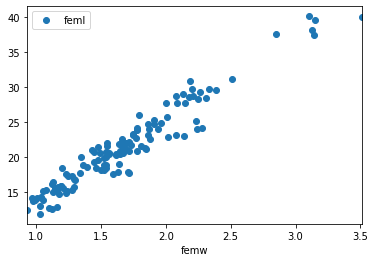

In [8]:
so.plot(style=['o'], x='femw', y='feml')

The width and length seem to correlate linearly. We will train linear regressor to give us the value 

In [9]:
fem = so[['feml', 'femw']]

fem_attr = fem.femw
fem_label = fem.feml

x_train, x_test, y_train, y_test = train_test_split(fem_attr, fem_label, test_size= 0.2, random_state=0)

# reshape because we have only 1 feature
x_train= x_train.values.reshape(-1, 1)
y_train= y_train.values.reshape(-1, 1)

x_test= x_test.values.reshape(-1, 1)
y_test= y_test.values.reshape(-1, 1)

fem_model = LinearRegression()
fem_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
print(fem_model.score(x_test, y_test))

0.9335327486724594


In [11]:
#accuracy is ok. we will use it to predict the missing feature
pred = fem_model.predict(x_test)
birds_data.loc[ [404], ['feml']] =  fem_model.predict([[1.77]]) 
birds_data[birds_data.isnull().any(axis=1)] #did it work

,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type
160,76.43,4.11,86.79,3.84,NaN,NaN,67.13,2.48,41.65,2.10,W
204,63.76,4.74,NaN,NaN,57.33,4.88,75.67,4.33,60.19,3.82,R
207,98.08,7.77,113.04,5.76,82.04,7.17,107.47,6.65,NaN,NaN,R
342,NaN,NaN,NaN,NaN,32.54,2.65,55.06,2.81,38.94,2.25,SO
378,20.10,1.86,NaN,1.52,17.21,1.22,NaN,NaN,18.46,0.91,SO
396,16.51,1.47,20.56,1.43,15.88,1.27,NaN,1.19,17.63,1.02,SO


Next we need Tibiotarsus length ( tibl ) on lines 378 and 396

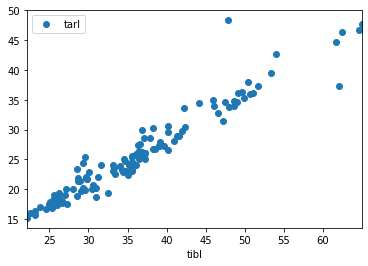

In [76]:
so.plot(style=['o'], x="tibl", y="tarl")
# logically as the bigger the individual the larger the bones

Tibl and Tarl show pretty linear correlation. We are going to repeat the prev step

In [13]:
tibl = so[['tibl', 'tarl']]
tibl_attr = tibl.tarl
tibl_label = tibl.tibl

x_train, x_test, y_train, y_test = train_test_split(tibl_attr, tibl_label, test_size= 0.2, random_state=1)

# reshape because we have only 1 feature
x_train= x_train.values.reshape(-1, 1)
y_train= y_train.values.reshape(-1, 1)

x_test= x_test.values.reshape(-1, 1)
y_test= y_test.values.reshape(-1, 1)

tibl_model = LinearRegression()
tibl_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
print(tibl_model.score(x_test, y_test))

0.948983134603131


In [15]:
#accuracy is ok. we will use it to predict the missing feature
pred = fem_model.predict(x_test)
birds_data.loc[ [378], ['tibl']] =  tibl_model.predict([[18.46]]) 
birds_data.loc[ [396], ['tibl']] =  tibl_model.predict([[17.63]]) 
birds_data[birds_data.isnull().any(axis=1)] #did it work

,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type
160,76.43,4.11,86.79,3.84,NaN,NaN,67.130000,2.48,41.65,2.10,W
204,63.76,4.74,NaN,NaN,57.33,4.88,75.670000,4.33,60.19,3.82,R
207,98.08,7.77,113.04,5.76,82.04,7.17,107.470000,6.65,NaN,NaN,R
342,NaN,NaN,NaN,NaN,32.54,2.65,55.060000,2.81,38.94,2.25,SO
378,20.10,1.86,NaN,1.52,17.21,1.22,26.892612,NaN,18.46,0.91,SO


In [16]:
print ( np.mean(so.tibl) )
print ( np.std(so.tibl) )
tibl_model.predict([[17.63]]) #reasable values

36.165725806451626
9.649952379406743


array([[25.8578503]])

In [17]:
#so.plot(style=['o'], x="tibw", y="femw")

TibW

In [18]:
table = so
attr = table.drop(['tibw', 'ulnal' ], axis=1) #unfortunatly also NaN in line 378
label = table.tibw

x_train, x_test, y_train, y_test = train_test_split(attr, label, test_size= 0.2, random_state=1)

tibw_model = LinearRegression()
tibw_model.fit(x_train, y_train)
print(tibw_model.score(x_test, y_test))

0.92227648585729


In [19]:
#apply to line 378 = tibw
line = birds_data.loc[378].drop(['tibw', 'type', 'ulnal'])
line

tibw_val = tibw_model.predict(line.values.reshape(1, -1)) 
print ( tibw_val )
birds_data.loc[ [378], ['tibw']] = tibw_val
birds_data[birds_data.isnull().any(axis=1)] #did it work

[1.1393542]


,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type
160,76.43,4.11,86.79,3.84,NaN,NaN,67.130000,2.480000,41.65,2.10,W
204,63.76,4.74,NaN,NaN,57.33,4.88,75.670000,4.330000,60.19,3.82,R
207,98.08,7.77,113.04,5.76,82.04,7.17,107.470000,6.650000,NaN,NaN,R
342,NaN,NaN,NaN,NaN,32.54,2.65,55.060000,2.810000,38.94,2.25,SO
378,20.10,1.86,NaN,1.52,17.21,1.22,26.892612,1.139354,18.46,0.91,SO


UlnaL

In [20]:
table = so
attr = table.drop(['ulnal' ], axis=1)
label = table.ulnal

x_train, x_test, y_train, y_test = train_test_split(attr, label, test_size= 0.2, random_state=1)

model = LinearRegression()
model.fit(x_train, y_train)
print(model.score(x_test, y_test))

0.9735497613298595


In [21]:
#apply to line 378 - ulnal
line = birds_data.loc[378].drop(['type', 'ulnal'])

val = model.predict(line.values.reshape(1, -1)) 
print ( np.mean(so.ulnal) )
print ( np.std(so.ulnal) )
print ( val )

#did it work
birds_data.loc[ [378], ['ulnal']] = val
birds_data[birds_data.isnull().any(axis=1)] 

26.479112903225808
6.947776392033963
[25.40640721]


,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type
160,76.43,4.11,86.79,3.84,NaN,NaN,67.13,2.48,41.65,2.10,W
204,63.76,4.74,NaN,NaN,57.33,4.88,75.67,4.33,60.19,3.82,R
207,98.08,7.77,113.04,5.76,82.04,7.17,107.47,6.65,NaN,NaN,R
342,NaN,NaN,NaN,NaN,32.54,2.65,55.06,2.81,38.94,2.25,SO


### Cleanup of Raptors ( R )

UlnaW - line 204

In [22]:
#assign raptors data to new variable
r = birds_data[birds_data.type == "R"].dropna().drop('type', axis = 1)

In [23]:
table = r
attr = table.drop(['ulnal', 'ulnaw' ], axis=1) #unfortunatly also NaN in line 204
label = table.ulnal

x_train, x_test, y_train, y_test = train_test_split(attr, label, test_size= 0.2)

model = LinearRegression()
model.fit(x_train, y_train)
print(model.score(x_test, y_test))

0.962736287472013


In [24]:
#apply to line 204 - ulnal
line = birds_data.loc[204].drop(['type', 'ulnal', 'ulnaw'])

val = model.predict(line.values.reshape(1, -1)) 
print ( np.mean(r.ulnal) )
print ( np.std(r.ulnal) )
print ( val )

#did it work
birds_data.loc[ [204], ['ulnal']] = val
birds_data[birds_data.isnull().any(axis=1)] 

100.07791666666667
37.76431279210205
[76.74733059]


,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type
160,76.43,4.11,86.790000,3.84,NaN,NaN,67.13,2.48,41.65,2.10,W
204,63.76,4.74,76.747331,NaN,57.33,4.88,75.67,4.33,60.19,3.82,R
207,98.08,7.77,113.040000,5.76,82.04,7.17,107.47,6.65,NaN,NaN,R
342,NaN,NaN,NaN,NaN,32.54,2.65,55.06,2.81,38.94,2.25,SO


My adding of ulnal although reasonable might increase the error, so I won't add it in ulnaw calc for line 204

In [25]:
label = table.ulnaw

x_train, x_test, y_train, y_test = train_test_split(attr, label, test_size= 0.2)

model = LinearRegression()
model.fit(x_train, y_train)
print(model.score(x_test, y_test))

0.9705886030669292


In [26]:
#apply to line 204 - ulnal
line = birds_data.loc[204].drop(['type', 'ulnal', 'ulnaw'])

val = model.predict(line.values.reshape(1, -1)) 
print ( np.mean(r.ulnaw) )
print ( np.std(r.ulnaw) )
print ( val )

#did it work
birds_data.loc[ [204], ['ulnaw']] = val
birds_data[birds_data.isnull().any(axis=1)] 

4.793541666666665
1.6439541883105773
[3.93029999]


,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type
160,76.43,4.11,86.79,3.84,NaN,NaN,67.13,2.48,41.65,2.10,W
207,98.08,7.77,113.04,5.76,82.04,7.17,107.47,6.65,NaN,NaN,R
342,NaN,NaN,NaN,NaN,32.54,2.65,55.06,2.81,38.94,2.25,SO


TarL line 207

In [27]:
table = r
attr = table.drop(['tarl', 'tarw' ], axis=1) #unfortunatly also NaN in line 204
label = table.tarl

x_train, x_test, y_train, y_test = train_test_split(attr, label, test_size= 0.2, random_state=12331)

model = LinearRegression()
model.fit(x_train, y_train)
print(model.score(x_test, y_test))

0.8705106730688443


In [28]:
#apply to line 207 - tarl
line = birds_data.loc[207].drop(['type', 'tarl', 'tarw'])

val = model.predict(line.values.reshape(1, -1)) 
print ( np.mean(r.tarl) )
print ( np.std(r.tarl) )
print ( val )

#did it work
birds_data.loc[ [207], ['tarl']] = val
birds_data[birds_data.isnull().any(axis=1)] 

59.14500000000003
19.09417221300782
[80.51985191]


,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type
160,76.43,4.11,86.79,3.84,NaN,NaN,67.13,2.48,41.650000,2.10,W
207,98.08,7.77,113.04,5.76,82.04,7.17,107.47,6.65,80.519852,NaN,R
342,NaN,NaN,NaN,NaN,32.54,2.65,55.06,2.81,38.940000,2.25,SO


TarW line 207

In [29]:
table = r
attr = table.drop(['tarl', 'tarw' ], axis=1) #unfortunatly also NaN in line 204
label = table.tarw

x_train, x_test, y_train, y_test = train_test_split(attr, label, test_size= 0.2, random_state=12331)

model = LinearRegression()
model.fit(x_train, y_train)
print(model.score(x_test, y_test))

0.8865725692098515


In [30]:
#apply to line 207 - tarw
line = birds_data.loc[207].drop(['type', 'tarl', 'tarw'])

val = model.predict(line.values.reshape(1, -1)) 
print ( np.mean(r.tarw) )
print ( np.std(r.tarw) )
print ( val )

#did it work
birds_data.loc[ [207], ['tarw']] = val
birds_data[birds_data.isnull().any(axis=1)] 

5.099999999999999
2.01351268516822
[5.40038531]


,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type
160,76.43,4.11,86.79,3.84,NaN,NaN,67.13,2.48,41.65,2.10,W
342,NaN,NaN,NaN,NaN,32.54,2.65,55.06,2.81,38.94,2.25,SO


### Cleanup of Wading Birds ( W )

In [31]:
w = birds_data[birds_data.type == "W"].dropna().drop('type', axis = 1)


FemL - line 160

In [32]:
table = w
attr = table.drop(['feml', 'femw' ], axis=1) #unfortunatly also NaN in line 204
label = table.feml

x_train, x_test, y_train, y_test = train_test_split(attr, label, test_size= 0.2)

model = LinearRegression()
model.fit(x_train, y_train)
print(model.score(x_test, y_test))

0.9084192958565467


In [33]:
#apply to line 160 - feml
line = birds_data.loc[160].drop(['type', 'feml', 'femw'])

val = model.predict(line.values.reshape(1, -1)) 
print ( np.mean(w.feml) )
print ( np.std(w.feml) )
print ( val )

#did it work
birds_data.loc[ [160], ['feml']] = val
birds_data[birds_data.isnull().any(axis=1)] 

40.11953125000002
17.5169043738548
[34.4851793]


,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type
160,76.43,4.11,86.79,3.84,34.485179,NaN,67.13,2.48,41.65,2.10,W
342,NaN,NaN,NaN,NaN,32.540000,2.65,55.06,2.81,38.94,2.25,SO


FemW - line 160

In [34]:
table = w
attr = table.drop(['feml', 'femw' ], axis=1) #unfortunatly also NaN in line 204
label = table.femw

x_train, x_test, y_train, y_test = train_test_split(attr, label, test_size= 0.2)

model = LinearRegression()
model.fit(x_train, y_train)
print(model.score(x_test, y_test))

0.9527581983065879


In [35]:
#apply to line 160 - femw
line = birds_data.loc[160].drop(['type', 'feml', 'femw'])

val = model.predict(line.values.reshape(1, -1)) 
print ( np.mean(w.femw) )
print ( np.std(w.femw) )
print ( val )

#did it work
birds_data.loc[ [160], ['femw']] = val
birds_data[birds_data.isnull().any(axis=1)] 

3.1185937499999996
1.398285632466034
[2.69240547]


,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type
342,NaN,NaN,NaN,NaN,32.54,2.65,55.06,2.81,38.94,2.25,SO


In [36]:
#line 342 is too corrupt. we are going to drop it
birds_data = birds_data.dropna()

# Data analysis

Check the number of specimens in each ecological group.

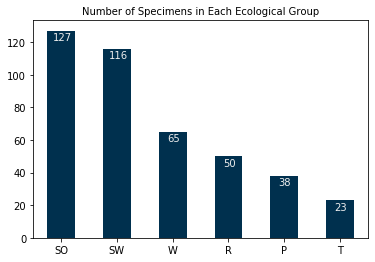

In [37]:
size_of_each_group = birds_data.groupby("type").size().sort_values(ascending=False)

ax = size_of_each_group.plot(
    kind="bar", 
    color="#00304e",
    figsize=((6, 4)),
    rot=0
)

ax.set_title("Number of Specimens in Each Ecological Group", fontsize=10)
ax.set_xlabel("")

for x, y in zip(np.arange(0, len(size_of_each_group)), size_of_each_group):
    ax.annotate("{:d}".format(y), xy=(x-(0.14 if len(str(y)) == 3 else 0.1), y-6), fontsize=10, color="#eeeeee")

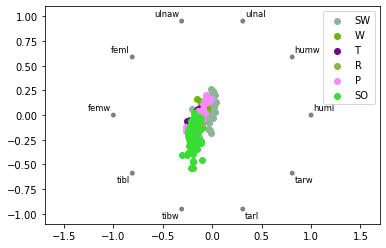

In [38]:
pd.plotting.radviz(birds_data, 'type')

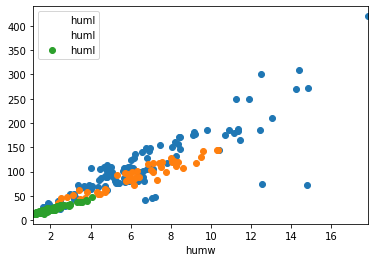

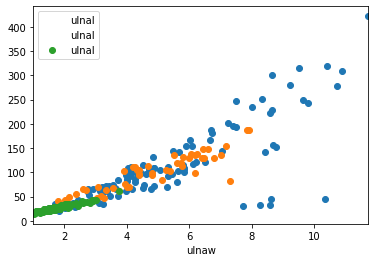

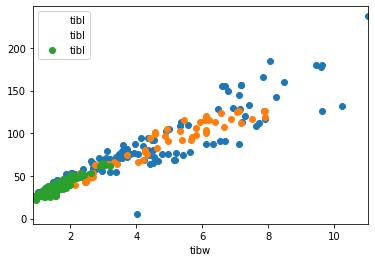

In [39]:
ax = plt.gca()

birds_data[birds_data.type == "SW"].plot(style=['o'], x="humw", y="huml", ax=ax)
birds_data[birds_data.type == "R"].plot(style=['o'], x="humw", y="huml", ax=ax)
birds_data[birds_data.type == "SO"].plot(style=['o'], x="humw", y="huml", ax=ax)

plt.show()

ax = plt.gca()

birds_data[birds_data.type == "SW"].plot(style=['o'], x="ulnaw", y="ulnal", ax=ax)
birds_data[birds_data.type == "R"].plot(style=['o'], x="ulnaw", y="ulnal", ax=ax)
birds_data[birds_data.type == "SO"].plot(style=['o'], x="ulnaw", y="ulnal", ax=ax)

plt.show()

ax = plt.gca()

birds_data[birds_data.type == "SW"].plot(style=['o'], x="tibw", y="tibl", ax=ax)
birds_data[birds_data.type == "R"].plot(style=['o'], x="tibw", y="tibl", ax=ax)
birds_data[birds_data.type == "SO"].plot(style=['o'], x="tibw", y="tibl", ax=ax)

plt.show()

# Now we test some models to see what will work

### First we devide the data:

In [40]:
birds_attr = birds_data.drop('type', axis = 1)
birds_label = birds_data.type

### Then we normalize the data

In [41]:
scaler = MinMaxScaler()
scaler.fit(birds_attr)
birds_attr = scaler.transform(birds_attr)

### Now we split test set

In [42]:
birds_attr_train, birds_attr_test, birds_labels_train, birds_labels_test = train_test_split(
    birds_attr, birds_label, train_size=0.7, stratify=birds_data.type)

### We setup cross validation

In [43]:
skf = StratifiedKFold(n_splits=5, shuffle=False)
k_fold = skf.split(birds_attr_train, birds_labels_train)

# Test DecisionTree:

In [44]:
params = { "max_depth" : [1, 5, 7, 15, 20],
           "min_samples_leaf" : [2, 5, 10, 12],
           "max_leaf_nodes" : [5, 10, 20]   }

grid_search = GridSearchCV(DecisionTreeClassifier(), params, cv=k_fold)
grid_search.fit(birds_attr_train, birds_labels_train)
tree_classifier = grid_search.best_estimator_

print("Decision tree; best score:", grid_search.best_score_)

Decision tree; best score: 0.6825938566552902


/home/default/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Decision Tree results:

In [45]:
prediction = tree_classifier.predict(birds_attr_test)
print(classification_report(birds_labels_test, prediction))

              precision    recall  f1-score   support

           P       0.56      0.45      0.50        11
           R       0.59      0.87      0.70        15
          SO       0.88      0.97      0.93        38
          SW       0.85      0.49      0.62        35
           T       1.00      0.86      0.92         7
           W       0.33      0.45      0.38        20

    accuracy                           0.69       126
   macro avg       0.70      0.68      0.68       126
weighted avg       0.73      0.69      0.69       126



# Logistic Regression:

In [46]:
k_fold = skf.split(birds_attr_train, birds_labels_train)

params = { "C" : [0.0001, 0.01, 0.1, 1, 10, 100, 10000],
           "max_iter" : [50, 100, 300, 1000],
           "fit_intercept" : [True, False]   }

grid_search = GridSearchCV(LogisticRegression(), params, cv=k_fold)
grid_search.fit(birds_attr_train, birds_labels_train)

logistic_classifier = grid_search.best_estimator_


print("Logistic Regression; best score:", grid_search.best_score_)

/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

Logistic Regression; best score: 0.8395904436860068


/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

### Logistic Regression Results: 

In [47]:
prediction = logistic_classifier.predict(birds_attr_test)
print(classification_report(birds_labels_test, prediction))

              precision    recall  f1-score   support

           P       0.89      0.73      0.80        11
           R       0.92      0.80      0.86        15
          SO       0.84      1.00      0.92        38
          SW       0.91      0.89      0.90        35
           T       0.86      0.86      0.86         7
           W       0.83      0.75      0.79        20

    accuracy                           0.87       126
   macro avg       0.88      0.84      0.85       126
weighted avg       0.88      0.87      0.87       126



# Random Forest:

In [48]:
k_fold = skf.split(birds_attr_train, birds_labels_train)

params = { "n_estimators" : [100, 200, 300],
           "max_depth" : [20, 50, 100]  }

grid_search = GridSearchCV(RandomForestClassifier(), params, cv=k_fold)
grid_search.fit(birds_attr_train, birds_labels_train)
forest_classifier = grid_search.best_estimator_

print("Random forest; best score:", grid_search.best_score_)

/home/default/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Random forest; best score: 0.7918088737201365


### Random Forest Results: 

In [49]:
prediction = forest_classifier.predict(birds_attr_test)
print(classification_report(birds_labels_test, prediction))

              precision    recall  f1-score   support

           P       0.83      0.91      0.87        11
           R       0.81      0.87      0.84        15
          SO       0.90      1.00      0.95        38
          SW       0.84      0.77      0.81        35
           T       1.00      0.86      0.92         7
           W       0.67      0.60      0.63        20

    accuracy                           0.84       126
   macro avg       0.84      0.83      0.84       126
weighted avg       0.84      0.84      0.84       126



# Linear SVM

In [50]:
k_fold = skf.split(birds_attr_train, birds_labels_train)

params = { "C" : [0.1, 0.5, 0.8, 1, 1.5, 2, 6, 10, 15, 20] }


grid_search = GridSearchCV(LinearSVC(), params, cv=k_fold)
grid_search.fit(birds_attr_train, birds_labels_train)
linear_svm_classifier = grid_search.best_estimator_

print("Linear SVM; best score:", grid_search.best_score_)

/home/default/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

Linear SVM; best score: 0.7747440273037542


/home/default/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Linear SVM Result

In [51]:
prediction = linear_svm_classifier.predict(birds_attr_test)
print(classification_report(birds_labels_test, prediction))

              precision    recall  f1-score   support

           P       0.86      0.55      0.67        11
           R       0.81      0.87      0.84        15
          SO       0.76      1.00      0.86        38
          SW       0.86      0.86      0.86        35
           T       0.83      0.71      0.77         7
           W       0.75      0.45      0.56        20

    accuracy                           0.80       126
   macro avg       0.81      0.74      0.76       126
weighted avg       0.80      0.80      0.79       126



### Gaussian SVM

In [52]:
k_fold = skf.split(birds_attr_train, birds_labels_train)

params = { "C" : [10, 15, 20, 50, 200],
           "gamma" : [ 0.001, 0.01, 0.1, 0.2]  }

grid_search = GridSearchCV(SVC(), params, cv=k_fold)
grid_search.fit(birds_attr_train, birds_labels_train)
gaussian_svm_classifier = grid_search.best_estimator_

print("Gaussian SVM; best score:", grid_search.best_score_)

Gaussian SVM; best score: 0.8122866894197952


/home/default/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Gaussian SVM Result:

In [53]:
prediction = linear_svm_classifier.predict(birds_attr_test)
print(classification_report(birds_labels_test, prediction))

              precision    recall  f1-score   support

           P       0.86      0.55      0.67        11
           R       0.81      0.87      0.84        15
          SO       0.76      1.00      0.86        38
          SW       0.86      0.86      0.86        35
           T       0.83      0.71      0.77         7
           W       0.75      0.45      0.56        20

    accuracy                           0.80       126
   macro avg       0.81      0.74      0.76       126
weighted avg       0.80      0.80      0.79       126



## Best classifier: 

# Logistic Regression & Random Forest

# Resample

In [54]:
from sklearn.utils import resample


In [55]:
birds_attr = birds_data.drop('type', axis = 1)
birds_label = birds_data.type

scaler = MinMaxScaler()
scaler.fit(birds_attr)


birds_attr_train, birds_attr_test, birds_labels_train, birds_labels_test = train_test_split(
    birds_attr, birds_label, train_size=0.7, stratify=birds_data.type)


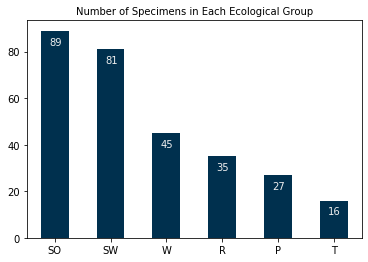

In [56]:
X = pd.concat([birds_attr_train, birds_labels_train], axis=1)

size_of_each_group = X.groupby("type").size().sort_values(ascending=False)

ax = size_of_each_group.plot(
    kind="bar", 
    color="#00304e",
    figsize=((6, 4)),
    rot=0
)

ax.set_title("Number of Specimens in Each Ecological Group", fontsize=10)
ax.set_xlabel("")

for x, y in zip(np.arange(0, len(size_of_each_group)), size_of_each_group):
    ax.annotate("{:d}".format(y), xy=(x-(0.14 if len(str(y)) == 3 else 0.1), y-6), fontsize=10, color="#eeeeee")

In [57]:
SW = X[X.type == "SW"]
W = X[X.type == "W"]
T = X[X.type == "T"]
R = X[X.type == "R"]
P = X[X.type == "P"]
SO = X[X.type == "SO"]

In [58]:
# upsample minority
SW_upsampled = resample(  SW,
                          replace=True, # sample with replacement
                          n_samples=len(SO), # match number in majority class
                          random_state=27) # reproducible results

W_upsampled = resample(   W,
                          replace=True, # sample with replacement
                          n_samples=len(SO), # match number in majority class
                          random_state=27) # reproducible results

T_upsampled = resample(   T,
                          replace=True, # sample with replacement
                          n_samples=len(SO), # match number in majority class
                          random_state=27) # reproducible results

R_upsampled = resample(   R,
                          replace=True, # sample with replacement
                          n_samples=len(SO), # match number in majority class
                          random_state=27) # reproducible results

P_upsampled = resample(   P,
                          replace=True, # sample with replacement
                          n_samples=len(SO), # match number in majority class
                          random_state=27) # reproducible results

In [59]:
T_upsampled.shape

(89, 11)

In [60]:
upsampled = pd.concat([SO, SW_upsampled, W_upsampled, T_upsampled, R_upsampled, P_upsampled])

In [61]:
print(upsampled.shape)
upsampled.head()

(534, 11)


,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type
311,22.26,1.77,24.58,1.67,21.28,1.68,36.06,1.43,24.14,1.41,SO
313,24.43,2.08,25.98,1.84,23.77,1.78,39.14,1.90,27.92,1.48,SO
354,28.14,2.35,30.63,1.86,28.49,2.18,49.07,2.07,34.64,1.78,SO
303,22.13,2.10,26.53,1.78,17.83,1.63,26.12,1.52,18.74,1.20,SO
369,13.48,1.27,16.00,1.00,12.67,1.10,23.12,0.88,16.34,0.89,SO


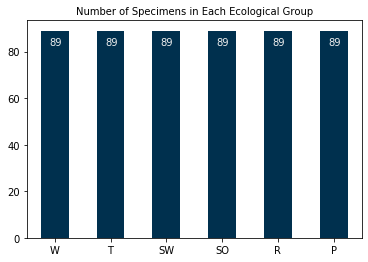

In [62]:
size_of_each_group = upsampled.groupby("type").size().sort_values(ascending=False)

ax = size_of_each_group.plot(
    kind="bar", 
    color="#00304e",
    figsize=((6, 4)),
    rot=0
)

ax.set_title("Number of Specimens in Each Ecological Group", fontsize=10)
ax.set_xlabel("")

for x, y in zip(np.arange(0, len(size_of_each_group)), size_of_each_group):
    ax.annotate("{:d}".format(y), xy=(x-(0.14 if len(str(y)) == 3 else 0.1), y-6), fontsize=10, color="#eeeeee")

### We setup cross validation

In [63]:
birds_attr_train = upsampled.drop('type', axis=1)
birds_labels_train = upsampled.type


birds_attr_train = scaler.transform(birds_attr_train)
birds_attr_test = scaler.transform(birds_attr_test)

skf = StratifiedKFold(n_splits=5, shuffle=False)
k_fold = skf.split(birds_attr_train, birds_labels_train)

# Test DecisionTree:

In [64]:
params = { "max_depth" : [1, 5, 7, 15, 20],
           "min_samples_leaf" : [2, 5, 10, 12],
           "max_leaf_nodes" : [5, 10, 20]   }

grid_search = GridSearchCV(DecisionTreeClassifier(), params, cv=k_fold)
grid_search.fit(birds_attr_train, birds_labels_train)
tree_classifier = grid_search.best_estimator_

print("Decision tree; best score:", grid_search.best_score_)

Decision tree; best score: 0.8146067415730337


/home/default/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Decision Tree Result:

In [65]:
prediction = tree_classifier.predict(birds_attr_test)
print(classification_report(birds_labels_test, prediction))

              precision    recall  f1-score   support

           P       0.60      0.55      0.57        11
           R       0.54      0.93      0.68        15
          SO       0.88      0.92      0.90        38
          SW       0.89      0.49      0.63        35
           T       0.56      0.71      0.63         7
           W       0.41      0.45      0.43        20

    accuracy                           0.68       126
   macro avg       0.65      0.67      0.64       126
weighted avg       0.72      0.68      0.68       126



# Logistic Regression: 

In [66]:
k_fold = skf.split(birds_attr_train, birds_labels_train)

params = { "C" : [0.0001, 0.01, 0.1, 1, 10, 100, 10000],
           "max_iter" : [50, 100, 300, 1000],
           "fit_intercept" : [True, False]   }

grid_search = GridSearchCV(LogisticRegression(), params, cv=k_fold)
grid_search.fit(birds_attr_train, birds_labels_train)

logistic_classifier = grid_search.best_estimator_


print("Logistic Regression; best score:", grid_search.best_score_)

/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

Logistic Regression; best score: 0.8913857677902621


/home/default/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


### Logistic Regression Result: 

In [67]:
prediction = logistic_classifier.predict(birds_attr_test)
print(classification_report(birds_labels_test, prediction))

              precision    recall  f1-score   support

           P       0.70      0.64      0.67        11
           R       0.79      1.00      0.88        15
          SO       0.90      0.97      0.94        38
          SW       0.96      0.71      0.82        35
           T       0.64      1.00      0.78         7
           W       0.68      0.65      0.67        20

    accuracy                           0.83       126
   macro avg       0.78      0.83      0.79       126
weighted avg       0.84      0.83      0.82       126



# Random Forest: 

In [68]:
k_fold = skf.split(birds_attr_train, birds_labels_train)

params = { "n_estimators" : [100, 200, 300],
           "max_depth" : [20, 50, 100]  }

rf_b_grid_search = GridSearchCV(RandomForestClassifier(), params, cv=k_fold)
rf_b_grid_search.fit(birds_attr_train, birds_labels_train)
forest_classifier = rf_b_grid_search.best_estimator_

print("Random forest; best score:", rf_b_grid_search.best_score_)

Random forest; best score: 0.949438202247191


/home/default/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Random Forest Result:

In [69]:
prediction = forest_classifier.predict(birds_attr_test)
print(classification_report(birds_labels_test, prediction))

              precision    recall  f1-score   support

           P       0.80      0.73      0.76        11
           R       0.71      1.00      0.83        15
          SO       0.84      1.00      0.92        38
          SW       0.92      0.69      0.79        35
           T       0.78      1.00      0.88         7
           W       0.60      0.45      0.51        20

    accuracy                           0.80       126
   macro avg       0.78      0.81      0.78       126
weighted avg       0.80      0.80      0.79       126



# Linear SVM: 

In [70]:
k_fold = skf.split(birds_attr_train, birds_labels_train)

params = { "C" : [0.1, 0.5, 0.8, 1, 1.5, 2, 6, 10, 15, 20] }


grid_search = GridSearchCV(LinearSVC(), params, cv=k_fold)
grid_search.fit(birds_attr_train, birds_labels_train)
linear_svm_classifier = grid_search.best_estimator_

print("Linear SVM; best score:", grid_search.best_score_)

/home/default/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

Linear SVM; best score: 0.8539325842696629


/home/default/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/default/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Linear SVM Result:

In [71]:
prediction = linear_svm_classifier.predict(birds_attr_test)
print(classification_report(birds_labels_test, prediction))

              precision    recall  f1-score   support

           P       0.75      0.55      0.63        11
           R       0.83      1.00      0.91        15
          SO       0.86      1.00      0.93        38
          SW       0.93      0.77      0.84        35
           T       0.58      1.00      0.74         7
           W       0.67      0.50      0.57        20

    accuracy                           0.82       126
   macro avg       0.77      0.80      0.77       126
weighted avg       0.82      0.82      0.81       126



# Gaussian SVM: 

In [72]:
k_fold = skf.split(birds_attr_train, birds_labels_train)

params = { "C" : [10, 15, 20, 50, 200],
           "gamma" : [ 0.001, 0.01, 0.1, 0.2]  }

grid_search = GridSearchCV(SVC(), params, cv=k_fold)
grid_search.fit(birds_attr_train, birds_labels_train)
gaussian_svm_classifier = grid_search.best_estimator_

print("Gaussian SVM; best score:", grid_search.best_score_)

Gaussian SVM; best score: 0.897003745318352


/home/default/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Gausian SVM Result:

In [73]:
prediction = linear_svm_classifier.predict(birds_attr_test)
print(classification_report(birds_labels_test, prediction))

              precision    recall  f1-score   support

           P       0.75      0.55      0.63        11
           R       0.83      1.00      0.91        15
          SO       0.86      1.00      0.93        38
          SW       0.93      0.77      0.84        35
           T       0.58      1.00      0.74         7
           W       0.67      0.50      0.57        20

    accuracy                           0.82       126
   macro avg       0.77      0.80      0.77       126
weighted avg       0.82      0.82      0.81       126



# =====================    Result   ======================

# Random Forest!!

In [74]:
rf_b_grid_search.best_params_

{'max_depth': 50, 'n_estimators': 100}

In [75]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))